MLP FOR A BINARY CLASSIFICATION PROBLEM: Physical or Non physical matrix?

The goal is to descriminate between matrices that are physical, i.e. that represent a quantum state, or matrices that are not physical. I use matrix with all the same size, associated to an Hilbert Space Dimension of 4: 4x4 matrices, i.e. 16 complex elements in each matrix.
I generated 300 physical and 300 non physical matrices through a MATLAB code (Dataset_creation.m) that I wrote. A physical matrix, also called Density matrix, must satisfy three requirements: it must be positive definite, hermitian, with trace equal to 1. In order to obtain this, in the MATLAB code, I first randomly generate 4x4 complex matrices. Each element of these matrices has real and imaginary part randomly extracted from a uniform distribution in the interval (-1,1). Then, I make matrices symmetric, with real diagonal values. To obtain positive definite matrices I use the Modified Cholesky Factorization. I found on internet a MATLAB code to implement this factorization (modchol_ldlt.m), for this I chose to generate matrices in MATLAB. Finally, I make matrices hermitian, and I normalize them to obtain trace equal to 1.
I also created non physical matrices. From these we can found: 75 randomly generated complex matrices, 75 positive definite complex matrices, 75 positive definite and hermitian matrices and 75 positive definite matrices with trace equal to 1.
I reshape each generated matrix in a row vector of shape (1x16). From the MATLAB code I saved real and imaginary part of Physical and Non Physical matrices in four '.txt' files. Each row of files represents a different matrix, the columns are real or imaginary matrices' elements. This is the starting point to build my dataset. I will build the dataset in this code.

I choose label 0 to classify Physical matrices, label 1 to classify Non Physical matrices.

First, I will implement a Multilayer Perceptron to solve the classification problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

DATASET CREATION

To create the dataset, first I import the generated data in MATLAB. I arranged the dataset matrix in a way that each row constitutes a different physical or non physical matrix. Each matrix (row) has 32 features that are the real and imaginary part of the elements of the matrix. The first 16 features are the real part of each element of the matrix, while the other 16 features are the imaginary part. The dataset has dimension (600,33) where the last column represents the label of the belonging class (0 or 1).

It is necessary to build the dataset in this way because it is not possible to have features that are complex number. Consequently I decide to split real and imaginary part as two different features and I built the dataset as described above.

In [2]:
#import data generated in MATLAB
physical_real=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_RealPart.txt')
Non_physical_real=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_RealPart.txt')
physical_imag=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_ImagPart.txt')
Non_physical_imag=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_ImagPart.txt')

################ TO CREATE THE DATASET #############

#Classifier: 0-> Physical matrix, 1-> Non physical matrix
target_Physical=np.zeros((physical_real.shape[0],1),dtype=int)
target_NonPhysical=np.ones((physical_real.shape[0],1),dtype=int)

Physical_data=np.concatenate((physical_real,physical_imag,target_Physical), axis=1)
NonPhysical_data=np.concatenate((Non_physical_real,Non_physical_imag,target_NonPhysical), axis=1)
#print("Physical data size:  ", Physical_data.shape, ", Non Physical data size: ", NonPhysical_data.shape)

dataset=np.concatenate((Physical_data,NonPhysical_data), axis=0)
np.random.shuffle(dataset)
print("Dataset dimension", dataset.shape)

features=dataset[:,:-1]
target=dataset[:,dataset.shape[1]-1]
print("features size: ", features.shape, ", target size: ", target.shape)



Dataset dimension (600, 33)
features size:  (600, 32) , target size:  (600,)


Now, I can split the dataset in train and validation set, with a ratio of 2:1

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.33, shuffle=False)
print("X_train: ",X_train.shape,", X_val: " ,X_val.shape, ", Y_train: ", Y_train.shape, ", Y_val: ",Y_val.shape)


X_train:  (402, 32) , X_val:  (198, 32) , Y_train:  (402,) , Y_val:  (198,)


BUILDING THE MLP MODEL

In [4]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [5]:
input_shape = X_train.shape[1]
#dropoutRate = 0.25


Now I implement MLP with only one layer. I try to change the number of neurons of the layer to see how this affect the accuracy and the ROC curve of the model.

In [ ]:
inputArray = Input(shape=(input_shape,))
neurons=[10,20,30,40,50,60]
models=[]

for n in neurons:

  #FIRST LAYER
  x = Dense(n, activation='relu')(inputArray)

  output=Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputArray, outputs=output)

  models=np.append(models,model)

#I saved all the models in the 'models' vector

In [ ]:
lr=0.01 #learning rate
opt = optimizers.legacy.Adam(learning_rate=lr)
for m in models:
  m.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
  m.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 20)       

In [ ]:
batch_size = 10
n_epochs = 250

history_=[]

#train
for m in models:
  m.summary()
  history=m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')

  history_=np.append(history_,history)
  del history,train_acc, val_acc




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
41/41 - 0s - loss: 0.2576 - accuracy: 0.8806 - val_loss: 0.3618 - val_accuracy: 0.8586 - lr: 0.0000e+00 - 206ms/epoch - 5ms/step
Epoch 2/250
41/41 - 0s - loss: 0.2576 - accuracy: 0.8806 - val_loss: 0.3618 - val_accuracy: 0.8586 - lr: 0.0000e+00 - 179ms/epoch - 4ms/step
Epoch 3/250
41/41 - 0s - loss: 0.2576 - accur

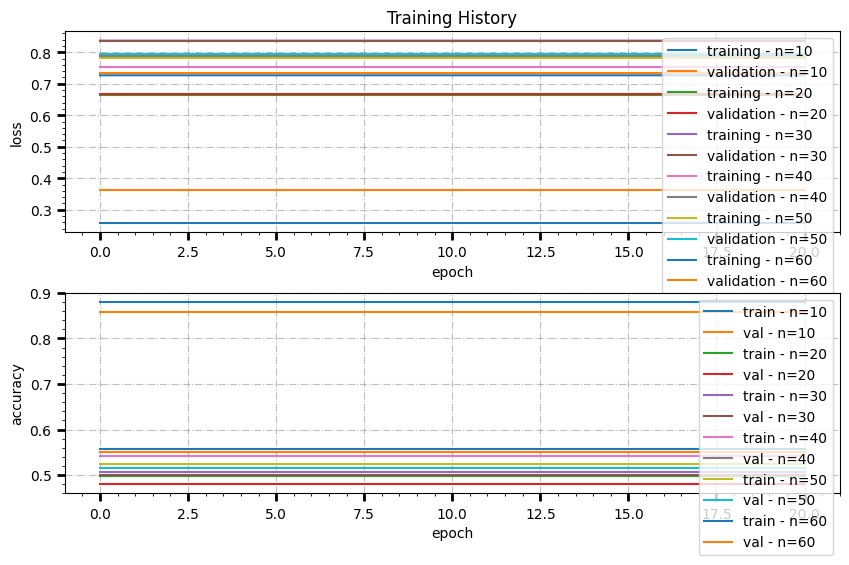

In [ ]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(10, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i,hist in enumerate(history_):
  ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[1]))
  ax0.plot(hist.history['val_loss'], label='validation - n='+str(models[i].layers[1].output.shape[1]))
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(history_):
  ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[1]))
  ax1.plot(hist.history['val_accuracy'], label='val - n='+str(models[i].layers[1].output.shape[1]))

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 3ms/step


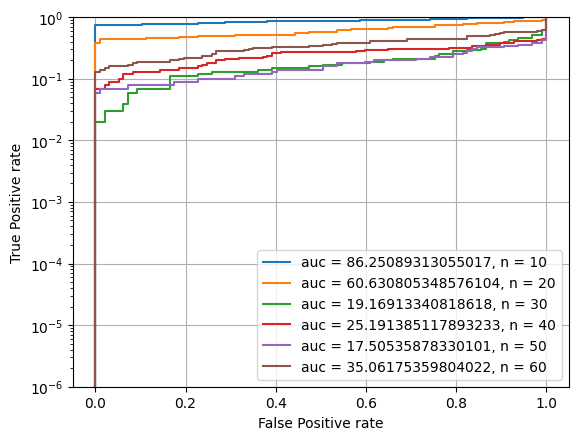

In [ ]:
# ROC curve

import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

for i in range(predict_val.shape[1]):
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  plt.plot(fpr_,tpr_,label='auc = '+ str(auc_*100.)+', n = '+str(models[i].layers[1].output.shape[1]))
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


After this analisys, it seems clear that the best number of neurons in the hidden layer, to reach the higher accuracy and auc parameter on the validation set, is 10. In fact, with n=10, we have a Train accuracy of 0.881 and a Validation accuracy of 0.859. The corrisponding AUC is 86.25%.

Now I can try to add another hidden layer and change the number of neurons in both the layers. I want to see if the accuracy and auc parameter improve.

In [6]:
dropoutRate=0.25
neurons_1=[5,25,50,70] #number of neurons in the first layer
neurons_2=[5,10,15,25,50] #number of neurons in the second layer
models2=[]

inputArray = Input(shape=(input_shape,))

for n1 in neurons_1:
  for n2 in neurons_2:
    #FIRST LAYER
    x = Dense(n1, activation='relu')(inputArray)
    x = Dropout(dropoutRate)(x)
    #SECOND LAYER
    x = Dense(n2, activation='relu')(x)
    output=Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputArray, outputs=output)
    models2=np.append(models2,model)

In [7]:
for m2 in models2:
  m2.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])
  m2.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
______________________________________________

In [8]:
batch_size = 30
n_epochs = 250

history_2=[]

#train
for m2 in models2:
  m2.summary()
  history=m2.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m2.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m2.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')

  history_2=np.append(history_2,history)
  del history,train_acc, val_acc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
14/14 - 6s - loss: 0.6598 - accuracy: 0.4900 - val_

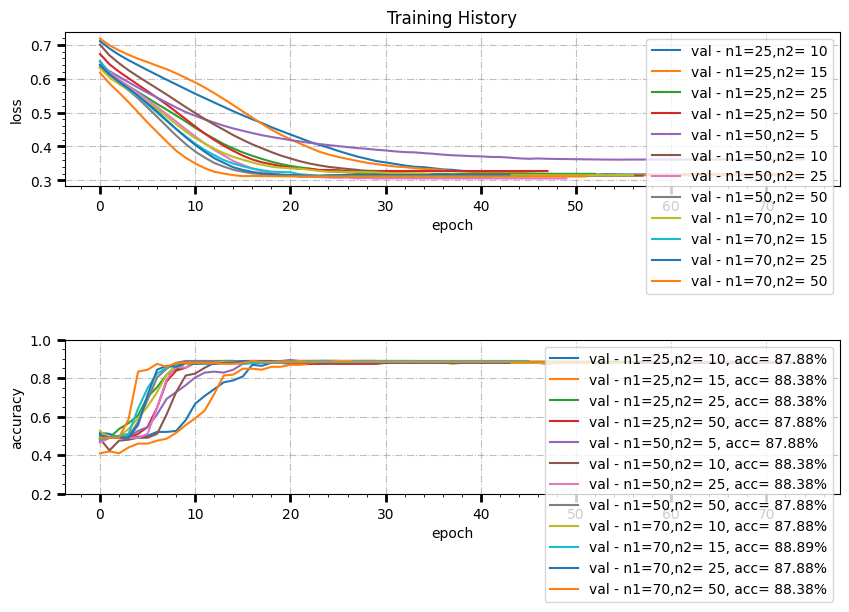

In [15]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(10, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1, wspace=0.3)

for i,hist in enumerate(history_2):
  if hist.history['val_accuracy'][-1]>0.875:
    ax0.plot(hist.history['val_loss'], label='val - n1='+ str(models2[i].layers[1].output.shape[1])+',n2= '+str(models2[i].layers[3].output.shape[1]))
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(history_2):
  if hist.history['val_accuracy'][-1]>0.875:
    ax1.plot(hist.history['val_accuracy'], label='val - n1='+ str(models2[i].layers[1].output.shape[1])+',n2= '+str(models2[i].layers[3].output.shape[1])+', acc= '+str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

I try with 20 different models. In the graph I show only the loss function and accuracy of the validation set, with an accuracy that exceed 0.875. In order to have a more understandable graph, I decide to do not show the training performances. The latters follow the same behaviour of the validation set (the loss function decreases while the accuracy increases).

In [16]:
#to find the model with the highest accuracy
train_acc=[]
val_acc=[]

for j,m2 in enumerate(models2):
  train_acc=np.append(train_acc,history_2[j].history['accuracy'][-1])
  val_acc=np.append(val_acc,history_2[j].history['val_accuracy'][-1])

max_val=np.max(val_acc)
max_arg=np.argmax(val_acc)
models2[max_arg].summary()
print("Training accuracy = ", train_acc[max_arg])
print("Validation accuracy = ", max_val)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_51 (Dense)            (None, 70)                2310      
                                                                 
 dropout_17 (Dropout)        (None, 70)                0         
                                                                 
 dense_52 (Dense)            (None, 15)                1065      
                                                                 
 dense_53 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
_________________________________________________________________
Training accuracy =  0.8731343150138855
Validation accur

7/7 [==============================] - 0s 2ms/step


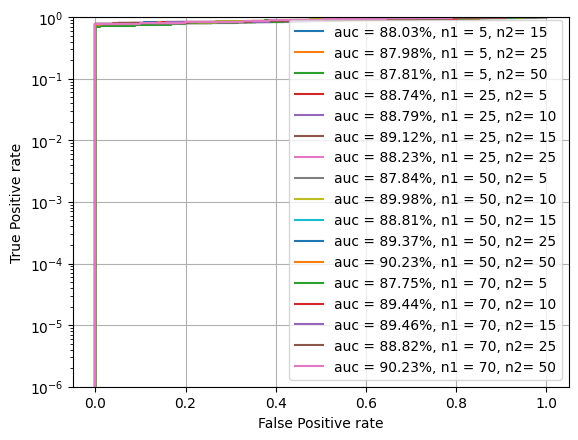

In [18]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models2):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

for i in range(predict_val.shape[1]):
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  if auc_>0.875:
    plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n1 = '+str(models2[i].layers[1].output.shape[1])+', n2= '+str(models2[i].layers[3].output.shape[1]))
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

Consequently, I can conclude that add a second hidden layer improve the algorithm performances. Both the AUC paramenter and the train and test accuracy increase. In particular we have the highest accuracy (train=0.873, test=0.889) with a model of 70 neurons in the first hidden layer and 15 in the second. The corresponding AUC is 89.46%.

The highest AUC value is 90.23% for two models: both with 50 neurons in the second layer and with 50 or 70 neurons in the first. The corresponding validation accuracies are 87.88% and 88.38%.

In both the cases, the MLP has good performances, the 'best' model depends a lot on the application. Since for me is important that both the True Positive and True Negative rates are maximized, the most important metric is the accuracy.

Finally, I fix the number of neurons in the two hidden layers (n1=70 and n2=15). I will try to change the dropout rate and the batch size.

In [19]:
DropOutRate=[0.05,0.1,0.25,0.5,0.7]

models3=[]

inputArray = Input(shape=(input_shape,))

for dor in DropOutRate:
  #FIRST LAYER
  x = Dense(70, activation='relu')(inputArray)
  x = Dropout(dor)(x)
  #SECOND LAYER
  x = Dense(15, activation='relu')(x)
  output=Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputArray, outputs=output)
  models3=np.append(models3,model)

In [20]:
for m3 in models3:
  m3.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])
  m3.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_60 (Dense)            (None, 70)                2310      
                                                                 
 dropout_20 (Dropout)        (None, 70)                0         
                                                                 
 dense_61 (Dense)            (None, 15)                1065      
                                                                 
 dense_62 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
_________________________________________________________________
Model: "model_21"
______________________________________

In [21]:
batch_size = 30
n_epochs = 250

history_3=[] #to save histories
#train
for m3 in models3:
  m3.summary()
  history=m3.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m3.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m3.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  history_3=np.append(history_3,history)
  del history,train_acc, val_acc

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_60 (Dense)            (None, 70)                2310      
                                                                 
 dropout_20 (Dropout)        (None, 70)                0         
                                                                 
 dense_61 (Dense)            (None, 15)                1065      
                                                                 
 dense_62 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
14/14 - 1s - loss: 0.7425 - accuracy: 0.4677

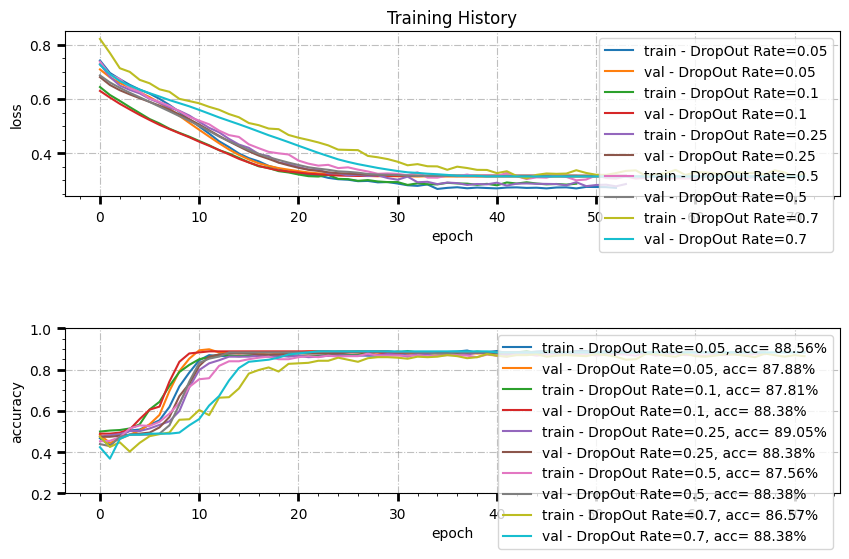

In [22]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(10, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.8, wspace=0.3)

for i,hist in enumerate(history_3):
    ax0.plot(hist.history['loss'],label='train - DropOut Rate='+ str(DropOutRate[i]))
    ax0.plot(hist.history['val_loss'], label='val - DropOut Rate='+ str(DropOutRate[i]))
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(history_3):
    ax1.plot(hist.history['accuracy'],label='train - DropOut Rate='+ str(DropOutRate[i])+', acc= '+str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
    ax1.plot(hist.history['val_accuracy'], label='val - DropOut Rate='+ str(DropOutRate[i])+', acc= '+str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 3ms/step


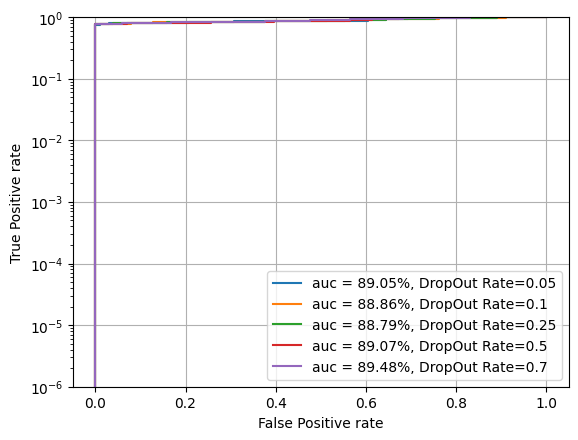

In [23]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models3):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

for i in range(predict_val.shape[1]):
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)

  plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, DropOut Rate='+ str(DropOutRate[i]))
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

The highest validation accuracy is 88.38% with a DropOut rate of 0.7, 0.5, 0.25 and 0.1 (train accuracy above 86.5%).  Since the best AUC parameter is 89.48% with a DropOut Rate of 0.7, I choose this as fixed DropOut Rate for the following investigations.

Finally I try to change the batch size to see if something change or improve.

In [24]:
DropOutRate=0.7

inputArray = Input(shape=(input_shape,))


  #FIRST LAYER
x = Dense(70, activation='relu')(inputArray)
x = Dropout(DropOutRate)(x)
  #SECOND LAYER
x = Dense(15, activation='relu')(x)
output=Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputArray, outputs=output)
model.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_75 (Dense)            (None, 70)                2310      
                                                                 
 dropout_25 (Dropout)        (None, 70)                0         
                                                                 
 dense_76 (Dense)            (None, 15)                1065      
                                                                 
 dense_77 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch_size = [1,25,30,45,60]
n_epochs = 250

history_4=[] #to save histories
#train
for batch in batch_size:
  history=model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = model.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = model.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  history_4=np.append(history_4,history)
  del history,train_acc, val_acc

Epoch 1/250
402/402 - 3s - loss: 0.6981 - accuracy: 0.4925 - val_loss: 0.6091 - val_accuracy: 0.4899 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 2/250
402/402 - 1s - loss: 0.5916 - accuracy: 0.6070 - val_loss: 0.5204 - val_accuracy: 0.7929 - lr: 0.0010 - 1s/epoch - 3ms/step
Epoch 3/250
402/402 - 1s - loss: 0.5029 - accuracy: 0.7960 - val_loss: 0.4244 - val_accuracy: 0.8838 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 4/250
402/402 - 2s - loss: 0.4509 - accuracy: 0.8234 - val_loss: 0.3660 - val_accuracy: 0.8889 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 5/250
402/402 - 2s - loss: 0.3949 - accuracy: 0.8433 - val_loss: 0.3298 - val_accuracy: 0.8838 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/250
402/402 - 2s - loss: 0.3551 - accuracy: 0.8557 - val_loss: 0.3371 - val_accuracy: 0.8838 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 7/250
402/402 - 1s - loss: 0.3668 - accuracy: 0.8358 - val_loss: 0.3090 - val_accuracy: 0.8889 - lr: 0.0010 - 1s/epoch - 3ms/step
Epoch 8/250
402/402 - 1s - loss: 0.3497 - accura

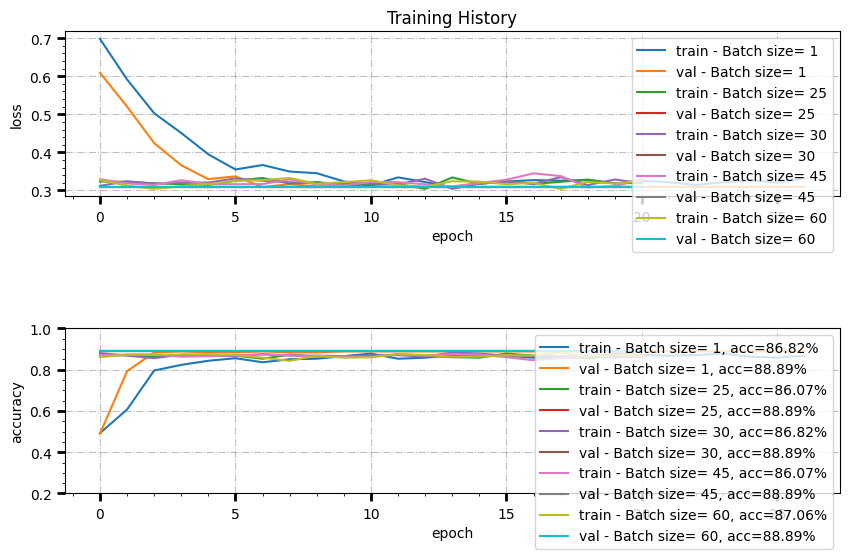

In [26]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(10, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.8, wspace=0.3)

for i,hist in enumerate(history_4):
    ax0.plot(hist.history['loss'],label='train - Batch size= '+str(batch_size[i]))
    ax0.plot(hist.history['val_loss'], label='val - Batch size= '+str(batch_size[i]))
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(history_4):
    ax1.plot(hist.history['accuracy'],label='train - Batch size= '+str(batch_size[i])+', acc='+str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
    ax1.plot(hist.history['val_accuracy'], label='val - Batch size= '+str(batch_size[i])+', acc='+str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

In this case the validation accuracy is the same in all the cases. What change is the training accuracy. The highest train accuracy is 87.06% that we obtain with a batch size =60.


Finally, we can conclude that the MLP can efficiently solve the binary classification problem that I propose. To reach validation accuracies exceeding 88% it needs only two layers. Also the AUC parameter exceed the 89%.

Now I am curious to see if by using a Convolutional Neural Network the performances could improve. In fact I can arrange the dataset in a way to have two channels: one for only the real part of each matrix and one for the imaginary part. I investigate this in the program (CNN.ipynb).